In [1]:
import matplotlib.mlab as griddata
import matplotlib.pyplot as plt
from pylab import *
import pandas as pd

In [2]:
# main.py


import numpy as np
from scipy.fftpack import fft, ifft
from scipy.signal import butter, lfilter
import scipy as sp
import matplotlib.pyplot as plt



def calc_fft(time_sec, vibr):
    """
    Inputs:
    time_sec: time in second
    vibr: vibration signal corresponding to time data.
    Outputs:
    frequency in Hz
    vibration fft in base units.
    """
    datalength_fft = len(time_sec)
    datalengthby2 = int(datalength_fft/2)
    timeavgcalc = np.array([], dtype = np.float64)
    time_sec_i = time_sec[1:]
    time_sec_i_1 = time_sec[:-1]
    timeavgcalc = time_sec_i - time_sec_i_1
    sigint_avg = np.mean(timeavgcalc)
    siginf = 1/(datalength_fft*sigint_avg)
    freqhztemp = np.arange(0,datalength_fft,dtype = np.float64)
    freqhz = freqhztemp*siginf
    freqhz = freqhz[0:datalengthby2]
    vibr_fft = np.abs(fft(vibr,axis = -1))
    vibr_fft = ((vibr_fft[0:datalengthby2])/datalength_fft)*2
    return freqhz,vibr_fft



def calc_3dfft(time_sec, speed_rpm, vibr):
    time_sec_i = time_sec[1:]
    time_sec_i_1 = time_sec[:-1]
    speed_rpm_i_1 = speed_rpm[:-1]
    cccum2_vect_temp = (((speed_rpm_i_1/2)/60)*360*(time_sec_i-time_sec_i_1))
    cccum2_vect_temp = np.insert(cccum2_vect_temp,0,0)
    cccum2_vect_temp = np.cumsum(cccum2_vect_temp)
    cycle_vect= np.floor(((cccum2_vect_temp/720.0))+1)
    ccrel2_vect_temp = cccum2_vect_temp-(cycle_vect-1)*720
    maxcy_vect = max(cycle_vect)
    alldata_vect = np.stack((cycle_vect, time_sec, speed_rpm, vibr_gf), axis = 1)
    e, inds = np.unique(alldata_vect[:,0], return_index=True)
    alldata_cycle_vect = np.split(alldata_vect, inds)[1:]
    speedindex = [(np.mean(alldata_cycle_vect[int(j)-1][:,2])) for j in e]

    freqhztemp_vibrffttemp = [(calc_fft((alldata_cycle_vect[int(j)-1][:,1]), (alldata_cycle_vect[int(j)-1][:,3]))) for j in e]
    freqhztemp = [freqhztemp_vibrffttemp[int(j)-1][0]  for j in e]
    vibrffttemp = [freqhztemp_vibrffttemp[int(j)-1][1]  for j in e]
    freqhz3d = np.array([], dtype = np.float64)
    vibrfft3d = np.array([], dtype = np.float64)
    freqhz3d = freqhztemp
    vibrfft3d = vibrffttemp
    freqhz3d = freqhz3d[:-1]
    vibrfft3d = vibrfft3d[:-1]
    e_1 = e[:-1]
    freqvibr3d_freq_interptemp = np.array([], dtype = np.float64)
    freqvibr3d_vibr_interptemp = np.array([], dtype = np.float64)
    freqvibr3d_vibr_interp = np.array([], dtype = np.float64)
    funcakimainterp = [(sp.interpolate.Akima1DInterpolator(freqhz3d[int(j)-1], vibrfft3d[int(j)-1])) for j in e_1] 
    tempceilval = int(max(e_1)-1)
    maxfreqval = ((np.around(max(freqhz3d[tempceilval]),decimals=-3)))
    freqvibr3d_freq_interptemp = np.array([np.arange(0, maxfreqval+0.1, 0.1)])
    freqvibr3d_vibr_interptemp = [(funcakimainterp[int(j)-1](freqvibr3d_freq_interptemp)) for j in e_1]
    freqvibr3d_freq_interp = freqvibr3d_freq_interptemp[0]
    freqvibr3d_vibr_interp = [(np.hstack((freqvibr3d_vibr_interp, freqvibr3d_vibr_interptemp[int(j)-1][0]))) for j in e_1]
    #freqvibr3d_vibr_interp = freqvibr3d_vibr_interp[:-1]
    lengrid = len(freqvibr3d_freq_interp)
    

    freq3dx = np.tile(freqvibr3d_freq_interp,(tempceilval+1,1))
    freq3dy = np.transpose(np.tile(speedindex[:-1], (lengrid,1)))
    freq3dz = freqvibr3d_vibr_interp
    freq3dz = np.array([arr.tolist() for arr in freq3dz])
    #maxz = np.amax(freq3dz)

        
    return freq3dx, freq3dy, freq3dz

def calc_rms_ampl(time_sec, speed_rpm, vibr):
    time_sec_i = time_sec[1:]
    time_sec_i_1 = time_sec[:-1]
    speed_rpm_i_1 = speed_rpm[:-1]
    cccum2_vect_temp = (((speed_rpm_i_1/2)/60)*360*(time_sec_i-time_sec_i_1))
    cccum2_vect_temp = np.insert(cccum2_vect_temp,0,0)
    cccum2_vect_temp = np.cumsum(cccum2_vect_temp)
    cycle_vect= np.floor(((cccum2_vect_temp/720.0))+1)
    ccrel2_vect_temp = cccum2_vect_temp-(cycle_vect-1)*720
    maxcy_vect = max(cycle_vect)
    alldata_vect = np.stack((cycle_vect, time_sec, speed_rpm, vibr_gf), axis = 1)
    e, inds = np.unique(alldata_vect[:,0], return_index=True)
    alldata_cycle_vect = np.split(alldata_vect, inds)[1:]
    speedindex = [(np.mean(alldata_cycle_vect[int(j)-1][:,2])) for j in e]
    rms_vibr = [(np.sqrt(np.mean(np.square((alldata_cycle_vect[int(j)-1][:,3]))))) for j in e]
    ampl_vibr = [((max(((alldata_cycle_vect[int(j)-1][:,3])))-min(((alldata_cycle_vect[int(j)-1][:,3]))))/2) for j in e]
    return speedindex, rms_vibr, ampl_vibr

def plot_3dfft(x,y,z, xlim, ylim):
    maxz = np.amax(z)
    CS = plt.contourf(x,y, z, 10, cmap = plt.cm.jet)
    
    norm = mpl.colors.Normalize(0,maxz,10)
    
    barcolors = plt.cm.ScalarMappable(norm, cmap="jet")
    bounds = np.linspace(0,maxz,10)
    
    plt.colorbar(cmap = "jet", norm=norm, orientation='vertical', spacing = 'proportional', ticks=bounds, boundaries=bounds)
    plt.xlim(xlim)
    plt.ylim(ylim)

In [3]:
#read signal
gasforce1 = pd.read_csv('gasforce1.tab', header = None, skiprows = 1, delimiter = '\t')
speedvstime = pd.read_csv('speedvstime.tab', header = None, skiprows = 1, delimiter = '\t')

In [4]:
time_sec = np.array(gasforce1[0])
speed_rpm = np.array(speedvstime[1])
vibr_gf = np.array(gasforce1[1])

In [5]:
rmsampl = calc_rms_ampl(time_sec,speed_rpm,vibr_gf)

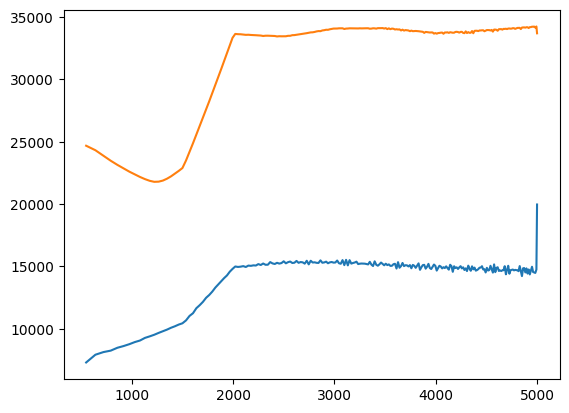

In [6]:
plt.plot(rmsampl[0], rmsampl[1])
plt.plot(rmsampl[0], rmsampl[2])

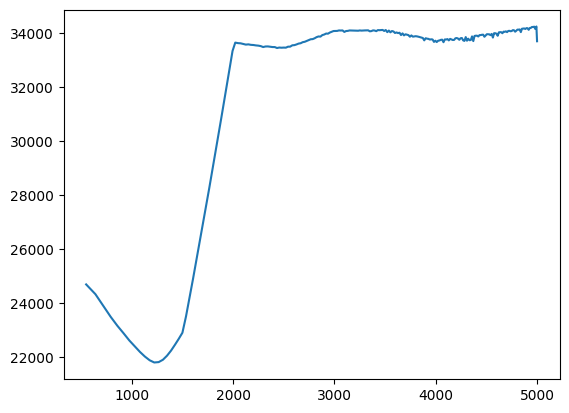

In [7]:
plt.plot(rmsampl[0], rmsampl[2])

In [8]:
x,y,z = calc_3dfft(time_sec,speed_rpm,vibr_gf)


Text(0, 0.5, 'speed [RPM]')

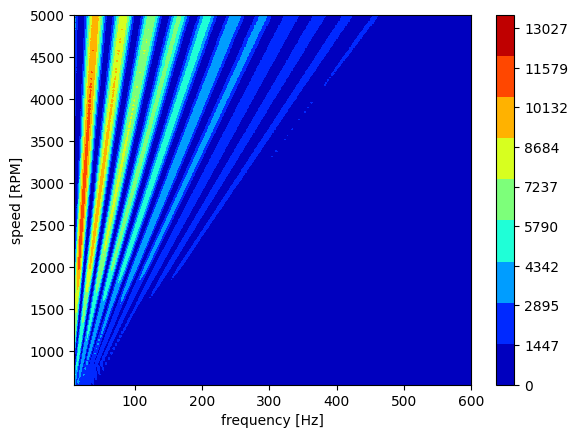

In [9]:
plot_3dfft(x,y,z,[10,600],[600,5000])
plt.xlabel('frequency [Hz]')
plt.ylabel('speed [RPM]')
